In [ ]:
# tools/devolucion_tools.py
from pydantic import BaseModel, Field
from datetime import datetime, timedelta
import pandas as pd
import os
import random

In [2]:
try:
    BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    # Si estás en un entorno interactivo sin __file__
    BASE_DIR = os.getcwd()

DOCS_DIR = os.path.join(BASE_DIR, "documents")
print("📂 BASE_DIR:", BASE_DIR)
print("📂 DOCS_DIR:", DOCS_DIR)

📂 BASE_DIR: d:\OneDrive - CGIAR\Desktop\codigos_dengue\trabajo_final
📂 DOCS_DIR: d:\OneDrive - CGIAR\Desktop\codigos_dengue\trabajo_final\documents


In [3]:
import os
from dotenv import load_dotenv

# LangChain + HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

c:\Users\dagudelo\venv_ia_generativa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from typing import Dict, List, Optional, Iterable, Any



def _get_openrouter_api_key() -> str:
    try:
        import environ
        env = environ.Env()
        environ.Env.read_env()
        key = env("OPENROUTER_API_KEY", default=None)
    except Exception:
        key = None
    key = key or os.getenv("OPENROUTER_API_KEY")
    if not key:
        raise RuntimeError(
            "OPENROUTER_API_KEY no encontrada. Añádela a tu .env o variables de entorno."
        )
    return key

def get_llm():
    """
    Devuelve un ChatOpenAI apuntando a OpenRouter usando el modelo:
    meta-llama/llama-3.3-70b-instruct:free (por defecto).
    Puedes cambiar el modelo/base_url por variables de entorno.
    """
    base_url = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")
    model = os.getenv("OPENROUTER_MODEL", "meta-llama/llama-3.3-70b-instruct:free")
    api_key = _get_openrouter_api_key()

    default_headers = {}
    if os.getenv("OPENROUTER_SITE_URL"):
        default_headers["HTTP-Referer"] = os.getenv("OPENROUTER_SITE_URL")
    if os.getenv("OPENROUTER_APP_NAME"):
        default_headers["X-Title"] = os.getenv("OPENROUTER_APP_NAME")

    llm = ChatOpenAI(
        model=model,
        api_key=api_key,
        base_url=base_url,
        timeout=60,
        max_retries=3,
        default_headers=default_headers or None,
    )
    return llm







In [23]:
from langchain_litellm import ChatLiteLLM

In [50]:
def build_policy_rag(k: int = 4):
    
    # 1️⃣ Cargar documentos Markdown
    policy_paths = [
        os.path.join(DOCS_DIR, "politicas_devoluciones_es_CO_2025-09.md"),
        os.path.join(DOCS_DIR, "politica_envios_es_CO_2025-09.md"),
    ]
    docs = [
        Document(page_content=open(p, "r", encoding="utf-8").read(),
                 metadata={"source": os.path.basename(p)})
        for p in policy_paths
    ]

    # 2️⃣ Embeddings BGE-M3
    embeddings = HuggingFaceEmbeddings(
        model_name="BAAI/bge-m3",
        model_kwargs={"device": "cpu"},           # Cambia a "cuda" si tienes GPU
        encode_kwargs={"normalize_embeddings": True},
    )

    # 3️⃣ Chunking semántico
    chunker = SemanticChunker(
        embeddings=embeddings,
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=65,
        min_chunk_size=100,
    )
    chunks = chunker.split_documents(docs)

    # 4️⃣ Vector store (FAISS)
    vs = FAISS.from_documents(chunks, embeddings)
    retriever = vs.as_retriever(search_kwargs={"k": k})

    # 5️⃣ LLM vía OpenRouter
    openrouter_key = os.getenv("OPENROUTER_API_KEY")
    if not openrouter_key:
        raise EnvironmentError("Falta OPENROUTER_API_KEY en el archivo .env")
    os.environ["OPENROUTER_API_KEY"] = openrouter_key
    
    

    llm = get_llm()

    # 6️⃣ Prompt base
    system_prompt = (
        "Eres un asistente de políticas de EcoMarket. "
        "El estado del producto debe ser entregado para aplicar devoluciones."
        "Responde con precisión basándote únicamente en el contexto proporcionado."
        "Si la información no está en el contexto, responde que no lo sabes. "
    )
    human_prompt = (
        "Pregunta: {question}\n\n"
        "Contexto recuperado:\n{context}\n\n"
        "Respuesta (con citas):"
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt),
    ])

    # 7️⃣ RAG Chain
    def _format_docs(docs):
        return "\n\n".join(
            f"{d.page_content}\n[Fuente: {d.metadata.get('source', 'desconocido')}]"
            for d in docs
        )

    rag_chain = (
        {"context": retriever | _format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    # 8️⃣ Helper
    def ask(question: str):
        docs = retriever.get_relevant_documents(question)
        answer = rag_chain.invoke(question)
        sources = list({d.metadata.get("source", "desconocido") for d in docs})
        return {"answer": answer, "sources": sources}

    return {"ask": ask, "retriever": retriever, "llm": llm}


In [6]:
rag = build_policy_rag(k=2)

question = "¿Cuál es el plazo máximo para devolver un producto dañado o defectuoso según la política?"

result = rag["ask"](question)

print("\n======================")
print("💬 Pregunta:", question)
print("----------------------")
print("🧠 Respuesta:")
print(result["answer"])
print("----------------------")
print("📚 Fuentes usadas:")
print(result["sources"])
print("======================")



c:\Users\dagudelo\venv_ia_generativa\Lib\site-packages\environ\environ.py:639: UserWarning: C:\Users\dagudelo\AppData\Local\Temp\ipykernel_35372\.env doesn't exist - if you're not configuring your environment separately, create one.
  warnings.warn(
C:\Users\dagudelo\AppData\Local\Temp\ipykernel_35372\2880067893.py:75: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)



💬 Pregunta: ¿Cuál es el plazo máximo para devolver un producto dañado o defectuoso según la política?
----------------------
🧠 Respuesta:
El plazo máximo para devolver un producto dañado o defectuoso, conocido como "DOA (daño a la llegada)", es de "7 días" según la política de devoluciones de EcoMarket.
----------------------
📚 Fuentes usadas:
['politicas_devoluciones_es_CO_2025-09.md']


In [39]:
chunks = rag["retriever"].vectorstore.docstore._dict.values()
for i, d in enumerate(chunks):
    print(f"--- Chunk {i+1} [{d.metadata['source']}] ---\n")
    print(d.page_content + "...\n")

--- Chunk 1 [politicas_devoluciones_es_CO_2025-09.md] ---

# Política de Devoluciones — EcoMarket (versión EcoMarket)

- **Ventana estándar**: 30 días
- **DOA (daño a la llegada)**: 7 días
- **Reembolso**: 5–10 días hábiles

## Requisitos

- Empaque original
- Producto sin uso
- Comprobante de compra
- El estado del producto debe ser Entregado para hacer devolución
 
## Categorías permitidas

- Hogar
- Cocina
- Energía
- Limpieza

## No retornables

- Perecederos
- Higiene/cosmética abiertos
- Ropa interior usada
- Productos personalizados

## Pasos

1. Solicitar número de seguimiento/pedido, fecha de entrega y motivo
2....

--- Chunk 2 [politicas_devoluciones_es_CO_2025-09.md] ---

Validar elegibilidad según la política
3. Generar etiqueta, empacar y entregar en el punto indicado
4. Procesar reembolso en 5–10 días hábiles tras recepción

## Alternativas

- Soporte de uso
- Cambio por artículo elegible
- Guía de reciclaje responsable

...

--- Chunk 3 [politica_envios_es_CO_2025-09.md]

In [42]:
# === LLM principal del agente ===


llm_basico =  get_llm()

c:\Users\dagudelo\venv_ia_generativa\Lib\site-packages\environ\environ.py:639: UserWarning: C:\Users\dagudelo\AppData\Local\Temp\ipykernel_35372\.env doesn't exist - if you're not configuring your environment separately, create one.
  warnings.warn(


In [43]:
import pandas as pd

# ========= CARGA DE BASE DE PEDIDOS =========
CSV_PEDIDOS_PATH = r'D:\OneDrive - CGIAR\Desktop\codigos_dengue\trabajo_final\documents\pedidos_2025-09.csv'

# Cargar el archivo CSV
PEDIDOS_DF = pd.read_csv(CSV_PEDIDOS_PATH, dtype=str,encoding="latin-1").fillna("")

# Asegurar que order_id sea índice
PEDIDOS_DF.columns = [c.lower().strip() for c in PEDIDOS_DF.columns]
if "order_id" in PEDIDOS_DF.columns:
    PEDIDOS_DF.set_index("order_id", inplace=True, drop=False)

In [27]:
PEDIDOS_DF["order_id"].head(10).tolist()

['2509001',
 '2509002',
 '2509003',
 '2509004',
 '2509005',
 '2509006',
 '2509007',
 '2509008',
 '2509009',
 '2509010']

In [28]:
DB_PATH = r"D:\OneDrive - CGIAR\Desktop\codigos_dengue\trabajo_final\data_log\eventos_devoluciones.db"


In [29]:
import sqlite3
import os
from typing import Optional, Dict, Any, Literal
from pydantic import BaseModel, Field
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

import os, csv, uuid, datetime
from typing import Optional, Dict, Any, Literal
from pydantic import BaseModel, Field
from langchain.tools import tool

from typing import TypedDict, Optional, Dict, Any, List
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import json, re, unicodedata
from langgraph.prebuilt.chat_agent_executor import AgentState




In [51]:


def _find_json_blob(s: str) -> str:
    s = s.strip()
    b, e = s.find("{"), s.rfind("}")
    return s[b:e+1] if b != -1 and e != -1 and e > b else s

def _normalize_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def _strip_accents(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def regex_order_id_guess(text: str) -> Optional[str]:
    """
    Heurística: ORD12345 o un número de 6-12 dígitos (ajusta a tu dataset).
    Luego valida contra PEDIDOS_DF.index.
    """
    text = _normalize_spaces(text)
    # patrón tipo ORD12345
    m = re.search(r"\bORD[-_ ]?(\d{4,12})\b", text, flags=re.IGNORECASE)
    candidates = []
    if m:
        candidates.append(m.group(0).replace(" ", "").replace("_", "").upper())
        candidates.append(m.group(1))  # solo dígitos

    # números sueltos
    for m2 in re.finditer(r"\b\d{6,12}\b", text):
        candidates.append(m2.group(0))

    # valida contra el índice del DF
    if "order_id" in PEDIDOS_DF.columns:
        ids = set(str(x) for x in PEDIDOS_DF["order_id"].tolist())
    else:
        ids = set(str(x) for x in PEDIDOS_DF.index.tolist())
    for c in candidates:
        if c in ids:
            return c
    return None

def extract_order_id_llm(user_text: str) -> Optional[str]:
    """
    Pide al LLM un JSON con {"order_id": "<id o null>"}. No inventar.
    """
    prompt = (
        "Eres un asistente de devoluciones. Extrae el order_id del siguiente mensaje si está presente.\n"
        "Formato típico: puede ser 'ORD12345' o solo dígitos como '2509006'.\n"
        "Devuelve SOLO un JSON válido con la forma exacta:\n"
        '{"order_id": "<id>" }  # o {"order_id": null}\n\n'
        f"Mensaje del usuario:\n{user_text}\n"
        "No inventes. Si no puedes extraerlo con alta confianza, usa null."
    )
    try:
        raw = llm.invoke(prompt)  # ChatLiteLLM: retorna string
        js = _find_json_blob(str(raw))
        data = json.loads(js)
        oid = data.get("order_id")
        # valida contra DF
        if oid:
            if "order_id" in PEDIDOS_DF.columns:
                ids = set(str(x) for x in PEDIDOS_DF["order_id"].tolist())
            else:
                ids = set(str(x) for x in PEDIDOS_DF.index.tolist())
            return oid if oid in ids else None
        return None
    except Exception:
        return None

def friendly_ask_for_order_id(previous_msg: Optional[str] = None) -> str:
    """
    Pide de forma amable el order_id al usuario usando el LLM, breve y claro.
    """
    prompt = (
        "Redacta un breve mensaje amable (máx. 2 líneas) pidiendo el order_id al cliente "
        "para gestionar una devolución. Da un ejemplo del formato. No uses jerga técnica."
    )
    try:
        return _normalize_spaces(str(llm.invoke(prompt)))
    except Exception:
        return "¿Me compartes tu order_id para ayudarte con la devolución? Ejemplo: 2509006"

def render_final_reply_with_llm(state: AgentState) -> str:
    """
    Genera respuesta amable y clara según el outcome del flujo.
    """
    pedido = state.get("pedido") or {}
    eleg = state.get("elegibilidad") or {}
    etq = state.get("etiqueta") or {}
    raw_reason = eleg.get("reason", "")
    base = {
        "order_id": state.get("order_id") or "",
        "name": pedido.get("name", ""),
        "status": pedido.get("status", ""),
        "category": pedido.get("category", ""),
        "eligible": bool(eleg.get("eligible", False)),
        "rma": etq.get("rma", ""),
        "label_url": etq.get("label_url", ""),
        "reason": raw_reason,
    }
    prompt = (
        "Eres un asistente de atención al cliente. Redacta una respuesta breve, amable y clara en español.\n"
        "Contexto JSON del caso:\n"
        f"{json.dumps(base, ensure_ascii=False)}\n\n"
        "Reglas:\n"
        "- Si eligible es true: felicita, muestra RMA y la URL de etiqueta en una lista.\n"
        "- Si eligible es false: explica con 1-2 frases la razón, invítalo a revisar la política y ofrece ayuda.\n"
        "- No uses tecnicismos; tono cordial.\n"
        "- No inventes datos que no estén en el JSON."
    )
    try:
        return str(llm.invoke(prompt)).strip()
    except Exception:
        # Fallback manual
        if base["eligible"]:
            return (
                "✅ Devolución elegible.\n\n"
                f"- RMA: {base['rma']}\n- Etiqueta: {base['label_url']}\n"
                "¿Necesitas algo más?"
            )
        else:
            reason = base["reason"] or "No cumple con los criterios de la política."
            return f"❌ No es elegible para devolución. Motivo: {reason}"






# Re-usa tu RAG
rag = build_policy_rag(k=4)  # <- tu función existente
llm = llm_basico              # <- tu ChatLiteLLM existente

# ---------- Pydantic Schemas ----------
class BuscarPedidoInput(BaseModel):
    order_id: str = Field(..., description="ID del pedido")

class VerificarElegibilidadInput(BaseModel):
    order_id: str
    status: str
    category: str

class GenerarEtiquetaInput(BaseModel):
    order_id: str
    customer_name: Optional[str] = Field(default="", description="Nombre del cliente")
    category: Optional[str] = Field(default="", description="Categoría del producto")
    status: Optional[str] = Field(default="", description="Estado del pedido/producto")
    
    
class RegistrarEventoSQLInput(BaseModel):
    order_id: str
    rma: str
    status: Literal["Procesando","En preparación","En tránsito","Retrasado","Entregado","Intento de entrega fallido","Retenido por aduana","En revisión de pago"]
    notes: Optional[str] = None
    reason: Optional[str] = None
    category: Optional[str] = None
    customer_name: Optional[str] = None
    

# ---------- Tools (simuladas) ----------
@tool("buscar_pedido", args_schema=BuscarPedidoInput)
def buscar_pedido(order_id: str) -> Dict[str, Any]:
    """
    Busca un pedido en el DataFrame PEDIDOS_DF por su order_id.
    Devuelve un dict con información básica del pedido o {} si no existe.
    """
    # Validaciones básicas
    if "order_id" not in PEDIDOS_DF.columns or order_id not in PEDIDOS_DF.index:
        return {}

    # Extraer la fila correspondiente
    row = PEDIDOS_DF.loc[order_id]

    # Construir respuesta limpia
    return {
        "order_id": row.get("order_id", ""),
        "name": row.get("customer_name", ""),
        "status": row.get("status", ""),
        "category": row.get("category", ""),
        "raw": row.to_dict(),
    }
    

@tool("verificar_elegibilidad_producto", args_schema=VerificarElegibilidadInput,    description="Verifica elegibilidad de devolución con RAG y devuelve {eligible, reason}.")
def verificar_elegibilidad_producto(order_id: str, status: str, category: str) -> Dict[str, Any]:
    prompt = (
        "Devuelve SOLO un JSON válido con esta forma exacta:\n"
        '{"eligible": true|false, "reason": "<texto detallado>"}\n\n'
        f"Decide elegibilidad:\nORDER_ID: {order_id}\nCATEGORIA: {category}\nESTADO_PRODUCTO: {status}"
    )
    out = rag["ask"](prompt)
    # Fallback por si el modelo añade texto extra antes/después
    s = out["answer"].strip()
    start = s.find("{"); end = s.rfind("}")
    if start != -1 and end != -1:
        s = s[start:end+1]
    try:
        data = json.loads(s)
        eligible = bool(data.get("eligible", False))
        reason = str(data.get("reason", "")).strip()
        return {"eligible": eligible, "reason": reason or out["answer"].strip()}
    except Exception:
        # fallback al método regex si no pudo parsear
        return verificar_elegibilidad_producto.__wrapped__(order_id, status, category)  # o retornar False con la respuesta cruda

def _rma_id(order_id: str, deterministic: bool = True) -> str:
    """Genera un ID único o determinístico para la devolución."""
    if deterministic:
        base = f"{order_id}"
        rma_core = uuid.uuid5(uuid.NAMESPACE_URL, base).hex[:8].upper()
    else:
        rma_core = uuid.uuid4().hex[:8].upper()
    today = datetime.date.today().strftime("%Y%m%d")
    return f"RMA-{today}-{rma_core}"

# ==== Tool ====
@tool("generar_etiqueta_devolucion", args_schema=GenerarEtiquetaInput)
def generar_etiqueta_devolucion(order_id: str,
                                customer_name: str = "",
                                category: str = "",
                                status: str = "") -> Dict[str, Any]:
    """
    Genera un RMA de devolución sin necesidad de SKU.
    Devuelve un texto imprimible y una URL simulada.
    """
    rma = _rma_id(order_id, deterministic=True)
    label_url = f"https://labels.ecomarket.test/{rma}.pdf"

    label_text = (
        f"=== ETIQUETA DE DEVOLUCIÓN ===\n"
        f"RMA: {rma}\n"
        f"Order ID: {order_id}\n"
        f"Cliente: {customer_name or 'N/D'}\n"
        f"Categoría: {category or 'N/D'}\n"
        f"Estado: {status or 'N/D'}\n"
        f"Fecha: {datetime.date.today().isoformat()}\n"
        f"===============================\n"
    )

    return {
        "rma": rma,
        "label_url": label_url,
        "label_text": label_text
    }


def _init_db():
    con = sqlite3.connect(DB_PATH)
    cur = con.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS eventos (
        event_id TEXT PRIMARY KEY,
        ts TEXT,
        order_id TEXT,
        status TEXT,
        rma TEXT,
        category TEXT,
        customer_name TEXT,
        reason TEXT,
        notes TEXT
    )
    """)
    con.commit()
    con.close()

_init_db()

@tool("registrar_evento_sql", args_schema=RegistrarEventoSQLInput)
def registrar_evento_sql(order_id: str,
                         status: str,
                         rma: Optional[str] = None,
                         notes: Optional[str] = None,
                         reason: Optional[str] = None,
                         category: Optional[str] = None,
                         customer_name: Optional[str] = None) -> Dict[str, Any]:
    """
    Registra un evento de devolución en SQLite (persistente y consultable).
    """
    event = {
        "event_id": str(uuid.uuid4()),
        "ts": datetime.datetime.now().isoformat(timespec="seconds"),
        "order_id": order_id,
        "status": status,
        "rma": rma or "",
        "category": category or "",
        "customer_name": customer_name or "",
        "reason": reason or "",
        "notes": notes or "",
    }
    try:
        con = sqlite3.connect(DB_PATH)
        cur = con.cursor()
        cur.execute("""
            INSERT INTO eventos(event_id, ts, order_id, status, rma, category, customer_name, reason, notes)
            VALUES(:event_id, :ts, :order_id, :status, :rma, :category, :customer_name, :reason, :notes)
        """, event)
        con.commit()
        con.close()
        ok = True
    except Exception as e:
        ok = False
        event["error"] = str(e)

    print("[LOG SQL]", event)
    return {"ok": ok, **event}

from typing import TypedDict, Optional, Dict, Any, List
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# ---------- Estado del grafo ----------
    
class AgentState(TypedDict):
    order_id: Optional[str]
    pedido: Optional[Dict[str, Any]]
    elegibilidad: Optional[Dict[str, Any]]
    etiqueta: Optional[Dict[str, Any]]
    event: Optional[Dict[str, Any]]
    respuesta: Optional[str]
    messages: List[Dict[str, str]]
    user_message: Optional[str]              # ← texto libre del usuario
    conversation_id: Optional[str]

# ---------- Nodos ----------
def router_node(state: AgentState) -> AgentState:
    """Valida/extrae order_id. Si falta, pide amablemente con LLM."""
    if state.get("order_id"):
        return state

    user_text = (state.get("user_message") or "").strip()

    # 1) intento por regex (rápido)
    oid = regex_order_id_guess(user_text) if user_text else None

    # 2) si falla, intento con LLM extractor
    if not oid and user_text:
        oid = extract_order_id_llm(user_text)

    if oid:
        state["order_id"] = oid
        return state

    # 3) si no hay order_id, pedimos amablemente
    ask = friendly_ask_for_order_id(user_text)
    state["respuesta"] = ask
    # opcional: preparar un evento de "falta dato" (no suelo loguear esto)
    return state

def buscar_pedido_node(state: AgentState) -> AgentState:
    """Busca el pedido por order_id y, si no existe, arma el evento y la respuesta."""
    if state.get("respuesta"):
        return state

    pedido = buscar_pedido.invoke({"order_id": state["order_id"]})
    if not pedido:
        state["respuesta"] = f"No encontré el pedido `{state['order_id']}`. ¿Podrías verificar el ID?"
        # Prepara el evento para que lo escriba el nodo registrar_evento
        state["event"] = {
            "order_id": state["order_id"],
            "rma": "",
            "status": "Procesando",  # valor por defecto si no hay pedido
            "notes": "Pedido no encontrado",
            "reason": "",
            "category": "",
            "customer_name": "",
        }
        return state

    state["pedido"] = pedido
    return state

def elegibilidad_node(state: AgentState) -> AgentState:
    """Consulta el RAG para decidir elegibilidad; si no elegible, arma evento y respuesta."""
    if state.get("respuesta"):
        return state

    pedido = state.get("pedido", {}) or {}
    status = pedido.get("status", "")
    category = pedido.get("category", "")

    out = verificar_elegibilidad_producto.invoke({
        "order_id": state["order_id"],
        "status": status,
        "category": category,
    })
    state["elegibilidad"] = out

    if not out.get("eligible", False):
        state["respuesta"] = f"❌ No elegible para devolución.\n\nMotivo:\n{out.get('reason','(sin detalle)')}"
        # Prepara evento para el nodo registrar_evento
        state["event"] = {
            "order_id": state["order_id"],
            "rma": "",
            "status": status or "Procesando",
            "notes": "No elegible para devolución",
            "reason": out.get("reason", ""),
            "category": category,
            "customer_name": pedido.get("name", ""),
        }
    return state

def etiqueta_node(state: AgentState) -> AgentState:
    """Genera RMA y etiqueta; arma el evento de éxito."""
    if state.get("respuesta"):
        return state

    pedido = state.get("pedido", {}) or {}
    etq = generar_etiqueta_devolucion.invoke({
        "order_id": state["order_id"],
        "customer_name": pedido.get("name",""),
        "category": pedido.get("category",""),
        "status": pedido.get("status",""),
    })
    state["etiqueta"] = etq

    # Prepara evento de éxito para el nodo registrar_evento
    state["event"] = {
        "order_id": state["order_id"],
        "rma": etq.get("rma",""),
        "status": pedido.get("status","Procesando"),
        "notes": "Etiqueta de devolución generada",
        "reason": (state.get("elegibilidad", {}) or {}).get("reason",""),
        "category": pedido.get("category",""),
        "customer_name": pedido.get("name",""),
    }
    return state

def registrar_evento_node(state: AgentState) -> AgentState:
    """Nodo explícito: escribe en SQLite el evento preparado en state['event']."""
    evt = state.get("event") or {}
    if not evt:
        # Nada que registrar; continúa.
        return state

    try:
        registrar_evento_sql.invoke(evt)
    except Exception as e:
        # No bloquea el flujo por fallo de logging; solo imprime.
        print("[registrar_evento_node] error:", e)
    finally:
        # (Opcional) limpiar el event para no re-loggear en branches siguientes
        # state["event"] = None
        pass
    return state

def responder_node(state: AgentState) -> AgentState:
    """Construye la respuesta final para el usuario con LLM (o fallback)."""
    # Si hay una respuesta previa (p.ej., falta order_id o pedido no encontrado), respóndela
    if state.get("respuesta"):
        return state

    # Genera respuesta amigable basada en el outcome del flujo
    answer = render_final_reply_with_llm(state)
    state["respuesta"] = answer
    return state

# ---------- Condiciones ----------
def falta_order_id(state: AgentState) -> bool:
    return not state.get("order_id")

def pedido_no_encontrado(state: AgentState) -> bool:
    # Se usa después de buscar_pedido: si ya hay respuesta, fue porque no encontró.
    return state.get("respuesta") is not None and (state.get("pedido") is None)

def no_elegible(state: AgentState) -> bool:
    return bool(state.get("elegibilidad") and not state["elegibilidad"]["eligible"])

def listo_para_log(state: AgentState) -> bool:
    # Si existe un payload de event, hay algo para registrar
    return state.get("event") is not None

# ---------- Grafo ----------
graph = StateGraph(AgentState)

graph.add_node("router", router_node)
graph.add_node("buscar_pedido", buscar_pedido_node)
graph.add_node("elegibilidad", elegibilidad_node)
graph.add_node("etiqueta", etiqueta_node)
graph.add_node("registrar_evento", registrar_evento_node)  # 👈 nodo explícito
graph.add_node("responder", responder_node)

graph.set_entry_point("router")

# router -> (falta) responder | (ok) buscar_pedido
graph.add_conditional_edges(
    "router",
    lambda s: "falta" if not s.get("order_id") else "ok",
    {"falta": "responder", "ok": "buscar_pedido"},
)

# buscar_pedido -> (no encontrado) registrar_evento | (ok) elegibilidad
graph.add_conditional_edges(
    "buscar_pedido",
    lambda s: "log" if pedido_no_encontrado(s) else "ok",
    {"log": "registrar_evento", "ok": "elegibilidad"},
)

# elegibilidad -> (no) registrar_evento | (sí) etiqueta
graph.add_conditional_edges(
    "elegibilidad",
    lambda s: "no" if no_elegible(s) else "si",
    {"no": "registrar_evento", "si": "etiqueta"},
)

# etiqueta -> registrar_evento (siempre)
graph.add_edge("etiqueta", "registrar_evento")

# registrar_evento -> responder (siempre)
graph.add_edge("registrar_evento", "responder")

# responder -> END
graph.add_edge("responder", END)

# Checkpointer en memoria (opcional)
memory = MemorySaver()
app = graph.compile(checkpointer=memory)

c:\Users\dagudelo\venv_ia_generativa\Lib\site-packages\environ\environ.py:639: UserWarning: C:\Users\dagudelo\AppData\Local\Temp\ipykernel_35372\.env doesn't exist - if you're not configuring your environment separately, create one.
  warnings.warn(


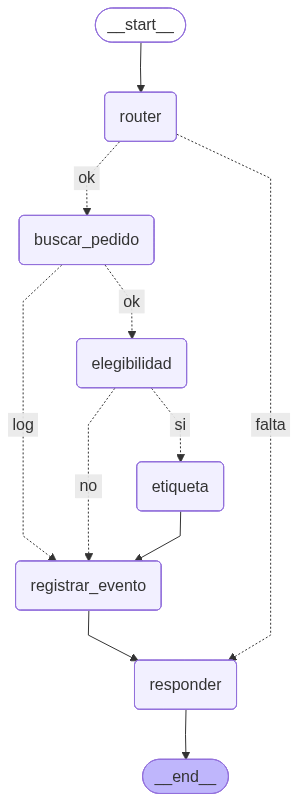

In [31]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [52]:
def run_chat_turn(user_text: str, order_id: Optional[str] = None):
    state: AgentState = {
        "order_id": order_id,
        "pedido": None,
        "elegibilidad": None,
        "etiqueta": None,
        "event": None,
        "respuesta": None,
        "messages": [],
        "user_message": user_text,
        "conversation_id": "demo-1",
    }
    out = app.invoke(state, config={"configurable": {"thread_id": state["conversation_id"]}})
    print(out["respuesta"])

# 1) Usuario escribe texto libre con el ID embebido:
run_chat_turn("Hola, quiero devolver lo del pedido 2509006.")

# 2) Usuario NO provee ID:
run_chat_turn("Quiero devolver un producto, me llegó defectuoso.")

# 3) Usuario responde con el ID (flujo continúa):
run_chat_turn("Es 2509006")

[LOG SQL] {'event_id': '318642f3-1f43-48fb-b6b2-6ec86ed31e5d', 'ts': '2025-10-27T23:38:05', 'order_id': '2509006', 'status': 'Intento de entrega fallido', 'rma': '', 'category': 'Limpieza', 'customer_name': 'Jorge Díaz', 'reason': "El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'Intento de entrega fallido'", 'notes': 'No elegible para devolución'}
❌ No elegible para devolución.

Motivo:
El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'Intento de entrega fallido'
content='Por favor, ¿podrías proporcionarme tu número de pedido para que pueda ayudarte con la devolución de tu compra? Por ejemplo, el formato es algo como "PED-XXXX-XXXXX".' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 56, 'total_tokens': 99, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.3-70b-instruct:free', 'system_

In [53]:

run_chat_turn("Hola, quiero devolver lo del pedido 2509013.")

[LOG SQL] {'event_id': 'e250cfdf-5e6d-450c-929d-3377f4a52b65', 'ts': '2025-10-27T23:39:08', 'order_id': '2509002', 'status': 'En preparación', 'rma': '', 'category': 'Higiene', 'customer_name': 'Luis Gómez', 'reason': "El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'En preparación'", 'notes': 'No elegible para devolución'}
❌ No elegible para devolución.

Motivo:
El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'En preparación'


In [55]:
# 1) Usuario escribe texto libre con el ID embebido:
run_chat_turn("ayudame con la devolucion de mi producto  2509010.")

[LOG SQL] {'event_id': '24e8baaf-dee4-4d5b-919b-a7830a7e2f54', 'ts': '2025-10-27T23:40:09', 'order_id': '2509010', 'status': 'En preparación', 'rma': '', 'category': 'Cocina', 'customer_name': 'Felipe Castro', 'reason': "El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'En preparación'", 'notes': 'No elegible para devolución'}
❌ No elegible para devolución.

Motivo:
El estado del producto debe ser 'Entregado' para hacer devolución, pero el estado actual es 'En preparación'


In [36]:
run_chat_turn(" ayudame con la devolución de mi pedido 2509006")


[LOG SQL] {'event_id': '997b7010-cb53-4f7e-8d85-375349ca9194', 'ts': '2025-10-27T23:23:54', 'order_id': '2509006', 'status': 'Intento de entrega fallido', 'rma': 'RMA-20251027-17A3480F', 'category': 'Limpieza', 'customer_name': 'Jorge Díaz', 'reason': "El producto pertenece a la categoría de Limpieza, que es una de las categorías permitidas para devolución según la política de devoluciones de EcoMarket, y el estado del producto es 'Intento de entrega fallido', lo que implica que el producto no ha sido entregado correctamente y, por lo tanto, puede ser considerado para devolución dentro de la ventana estándar de 30 días o según las condiciones específicas de daño a la llegada o reembolso.", 'notes': 'Etiqueta de devolución generada'}
content='Estimado Jorge Díaz,\n\nMe alegra informarte que tu solicitud para el pedido con ID 2509006 es elegible para devolución. A continuación, te proporciono los detalles necesarios para proceder:\n\n* RMA: RMA-20251027-17A3480F\n* URL de etiqueta: https

In [71]:
initial_state = {
    "order_id": "ORD123",
    "sku": "SKU-AAA",
    "motivo": "Producto defectuoso",
    "pedido": None,
    "elegibilidad": None,
    "etiqueta": None,
    "respuesta": None,
    "messages": []
}
final_state = app.invoke(initial_state)
print(final_state["respuesta"])

[LOG] {'order_id': 'ORD123', 'sku': 'SKU-AAA', 'status': 'NO_ELEGIBLE', 'notes': "Elegible: SI\n\nEl motivo 'Producto defectuoso' se ajusta a la categoría de DOA (daño a la llegada), que tiene una ventana de 7 días según la política [Fuente: politicas_devoluciones_es_CO_2025-09.md]. Para proceder, se requiere que el cliente cumpla con los requisitos como empacar el producto en su embalaje original, que esté sin uso y tenga el comprobante de compra [Fuente: politicas_devoluciones_es_CO_2025-09.md]."}
No elegible para devolución. Motivo: Elegible: SI

El motivo 'Producto defectuoso' se ajusta a la categoría de DOA (daño a la llegada), que tiene una ventana de 7 días según la política [Fuente: politicas_devoluciones_es_CO_2025-09.md]. Para proceder, se requiere que el cliente cumpla con los requisitos como empacar el producto en su embalaje original, que esté sin uso y tenga el comprobante de compra [Fuente: politicas_devoluciones_es_CO_2025-09.md].
